<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

По условию соревнования, нам нужно самостоятельно собрать обучающий датасет. 

## Парсер сайта AUTO.RU (Актуальность: декабрь 2020 г.)

In [ ]:
"""
from fake_useragent import UserAgent 
from bs4 import BeautifulSoup    
import requests  
import re
import time
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm.notebook import tqdm




# Функция по извлечению данных со страницы объявления в словарь data_dict
def parsing_page_one_ad(url):

    response = requests.get(url, headers={'User-Agent': UserAgent().chrome})    
    response.encoding ='utf8'   
    
    # Теперь создадим объект BeautifulSoup, указывая html парсер    
    page = BeautifulSoup(response.text, 'html.parser')
    data_dict = {}

    data_dict['car_url'] = url
    data_dict['parsing_unixtime'] = int(time.time())


     # в разделах script ищем вхождение 'complectation":{"id"'
    for script in page.find_all("script"):
        if 'complectation":{"id"' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
    # в a  ищем 'complectation":' и содержимое между {}. Отсекаем начало, оставляя только содержимое словаря
            data_dict['complectation_dict'] = re.search(r'complectation":{"id.*?}', a)[0][15:]

        if 'equipment":{' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
        # в a  ищем 'equipment":' и содержимое между {}. Отсекаем начало, оставляя только содержимое словаря
            data_dict['equipment_dict'] = re.search(r'equipment":{.*?}', a)[0][11:]

        if '{"mileage":' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
        # в a  ищем '{"mileage":' и содержимое между {}. Отсекаем начало, оставляя только содержимое словаря
            data_dict['mileage'] = re.search(r'"mileage":\d*', a)[0][10:]

        if '"model_info":' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
            data_dict['model_info'] = re.search(r'"model_info":{.*?}', a)[0][13:]
            data_dict['model_name'] = re.search(r'model_info":{"code":".*?"', a)[0][20:].strip('"')

        if 'super_gen":{' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
            data_dict['super_gen'] = re.search(r'super_gen":{.*?}', a)[0][11:] 

        if 'vendor":"' in str(script):
            a = str(script)  # присваиваем a содержимое скрипта как строку
            data_dict['vendor'] = re.search(r'vendor":".*?"', a)[0][9:].strip('"')


    for tag in page.find_all('div'):
        if tag.get("title") == "Идентификатор объявления":
            data_dict['sell_id'] = re.search(r'\d+', tag.text)[0]


    for tag in page.find_all("meta"):
        if tag.get("itemprop") == "bodyType":
            data_dict['bodyType'] = tag.get("content")

        if tag.get("itemprop") == "brand":
            data_dict['brand'] = tag.get("content")

        if tag.get("itemprop") == "color":
            data_dict['color'] = tag.get("content")

        if tag.get("itemprop") == "description":
            data_dict['description'] = tag.get("content")

        if tag.get("itemprop") == "engineDisplacement":
            data_dict['engineDisplacement'] = tag.get("content")

        if tag.get("itemprop") == "enginePower":
            data_dict['enginePower'] = tag.get("content")

        if tag.get("itemprop") == "fuelType":
            data_dict['fuelType'] = tag.get("content")

        if tag.get("itemprop") == "modelDate":
            data_dict['modelDate'] = tag.get("content")

        if tag.get("itemprop") == "name":
            data_dict['name'] = tag.get("content")

        if tag.get("itemprop") == "numberOfDoors":
            data_dict['numberOfDoors'] = tag.get("content")

        if tag.get("itemprop") == "price":
            data_dict['price'] = tag.get("content")

        if tag.get("itemprop") == "priceCurrency":
            data_dict['priceCurrency'] = tag.get("content")

        if tag.get("itemprop") == "productionDate":
            data_dict['productionDate'] = tag.get("content")

        if tag.get("itemprop") == "vehicleConfiguration":
            data_dict['vehicleConfiguration'] = tag.get("content")

        if tag.get("itemprop") == "vehicleTransmission":
            data_dict['vehicleTransmission'] = tag.get("content")


    span_CardInfoRow__cell = page.find_all('span', {'class': 'CardInfoRow__cell'})

    for i,tag in enumerate (span_CardInfoRow__cell):
        if tag.text == "Владельцы":
            data_dict['Владельцы'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел

        if tag.text == "Владение":
            data_dict['Владение'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел    

        if tag.text == "ПТС":
            data_dict['ПТС'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел    

        if tag.text == "Привод":
            data_dict['Привод'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел 

        if tag.text == "Руль":
            data_dict['Руль'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел

        if tag.text == "Состояние":
            data_dict['Состояние'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел 

        if tag.text == "Таможня":
            data_dict['Таможня'] = span_CardInfoRow__cell[i+1].text.replace(u'\xa0', u' ') # в  конце заменяем юникодовский пробел

    return data_dict

    
# Функция по созданию списка ссылок links_list  на объявления о продаже автомобилей  
def extraction_links(url):
    links_list =[] 
    response = requests.get(url, headers={'User-Agent': UserAgent().chrome})  
    response.encoding ='utf8'
    page = BeautifulSoup(response.text, 'html.parser') 
    links = page.find_all('a', class_='Link ListingItemTitle-module__link')
    
    for link in links:
        links_list.append(link.get("href"))
    return links_list
    
    
    
    
    
df = pd.DataFrame() # инициализируем итоговый датафрейм 

url_link_list = [] # список страниц по годам и номерам от 1 до 99

ranges = [range(2006, 2011), range(1, 100)] # указываем года и диапазон страниц, которые будем парсить 

# index[0] - year, index[1] - page 
for index in itertools.product(*ranges):
    # формируем ссылки страницы со списками объявлений
    на  = (f"https://auto.ru/moskva/cars/{index[0]}-year/all/?output_type=table&page={index[1]}")
    url_link_list.append(url_links) # заносим их в список
    
links_list = [] # список списков ссылок на объявления c одной страницы таблицы объявлений

#for url_links in url_link_list:
# извлекаем в links_list список ссылок на объявления
try:
        #links_list = extraction_links(url_links)
    links_list = Parallel(n_jobs = 2)(delayed(extraction_links)(url_links) for url_links in url_link_list)
except:
    pass 

ads_dict_list = [] # список словарей содержимого объявлений

for links in links_list:
    try:
        ads_dict_list = Parallel(n_jobs = 2)(delayed(parsing_page_one_ad)(ad_url) for ad_url in links)
    except:
        pass
    
    for ad in ads_dict_list:
        try:
            df = df.append(ad, ignore_index=True)
        except:
            pass

df.to_csv('_auto_ru_XXXX-XXXX.csv', encoding = 'utf-8', index=False) # записываем содержимое датафрейма в файл
"""

## Объединение спарсенных датафреймов в один и его первичная обработка

In [ ]:
"""
import os
import pandas as pd
import numpy as np

df = pd.DataFrame()
list_file = os.listdir(path=".") # получение списка файлов в папке

for file in list_file:
    if '.csv' in file: # если у файла расширение .csv, то читаем его как DF
        df_temp = pd.read_csv(file)
        df = pd.concat([df, df_temp], ignore_index=True)
        
df = df.drop_duplicates(subset=['car_url']) # удаление дубликатов по URL объявления

df = df.replace('{}',  None) # замена пустых словарей на NaN
df['mileage'] = df['mileage'].apply(lambda x: int(x) if type(x) == str else x) # приведение 'mileage' к числовму виду
df = df.replace(np.nan,  None)

df.to_csv('auto_ru_moskva_12_12_2020.csv', encoding = 'utf-8', index=False)
"""

Подгружаем библиотеки и наш датасет

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

In [2]:
pd.set_option('display.max_columns', None) #отображение всех столбцов датасета

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

### Определение базовых функций

In [6]:
# Функция по сбору информации по каждому столбцу


def my_describe(df):
    """Отображение описательных статистик датафрейма в удобной форме"""
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values 
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return


def show_plot_boxplot(df, column, bins=80):
    """Построение гистограммы по столбцу и boxplot-а"""
    color_text = plt.get_cmap('PuBuGn')(0.9)
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (10, 4)
    _, axes = plt.subplots(2, 1)
    axes[0].hist(df[column], bins=bins)
    axes[0].set_title("Гистограмма и boxplot для признака "+column)
    axes[1].boxplot(df[column], vert=False, showmeans = True)
    axes[1].set_title('')
    return


# Пропишем функцию расчета IQR и квартилей.

def IQR_perc(df,list_cols):
    temp = {}
    temp['Имя признака'] = list_cols
    temp['IQR'] = df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25)
    temp['perc25'] = df[list_cols].quantile(0.25)
    temp['perc75'] = df[list_cols].quantile(0.75)
    temp['Л. граница выбросов'] = df[list_cols].quantile(0.25) - 1.5*(df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25))
    temp['П. граница выбросов'] =df[list_cols].quantile(0.75) + 1.5*(df[list_cols].quantile(0.75) - df[list_cols].quantile(0.25))
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T)
    return


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)) # функция вычисления MAPE – средней абсолютной ошибки

# Setup

In [7]:
VERSION    = 15
#DIR_TRAIN = '/kaggle/input/autorumoskva/' # подключил к ноутбуку внешний датасет
#DIR_TEST   = '/kaggle/input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

## CATBOOST
ITERATIONS = 5000
LR         = 0.1

# Data

In [8]:
#!ls '../input'

In [9]:
#train = pd.read_csv(DIR_TRAIN+'auto_ru_moskva_12_12_2020.csv') # датасет для обучения модели
#test = pd.read_csv(DIR_TEST+'test.csv')
#sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [10]:
train = pd.read_csv('auto_ru_moskva_12_12_2020.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [11]:
train.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,price,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
15505,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/primera/...,чёрный,"{""id"":""0""}",Автомобиль в хорошем состоянии дополнительных ...,1.8 LTR,116 N12,"{""tinted-glass"":true,""airbag-driver"":true,""iso...",бензин,132000,2001,"{""code"":""PRIMERA"",""name"":""Primera"",""ru_name"":""...",PRIMERA,1.8 AT (116 л.с.),4,1607754174,290000,RUB,2006,1101645132,"{""id"":""3480665"",""name"":""III (P12)"",""ru_name"":""...",SEDAN AUTOMATIC 1.8,автоматическая,JAPANESE,1 владелец,14 лет и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен
46424,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/qashqai/...,белый,"{""id"":""20109552"",""name"":""LE+"",""available_optio...",Автомобили с пробегом от Официального Дилера У...,2.0 LTR,144 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,103000,2013,"{""code"":""QASHQAI"",""name"":""Qashqai"",""ru_name"":""...",QASHQAI,2.0 CVT (144 л.с.),5,1607705633,1210000,RUB,2015,1101643581,"{""id"":""20097928"",""name"":""II"",""ru_name"":""2"",""ye...",ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,2 владельца,4 года и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
23459,внедорожник 5 дв.,LAND_ROVER,https://auto.ru/cars/used/sale/land_rover/rang...,чёрный,"{""id"":""2424206"",""name"":""4.2 Supercharged"",""ava...","Пpодaю oтличный автoмобиль, вcвязи с приобрeте...",4.2 LTR,396 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,291728,2005,"{""code"":""RANGE_ROVER"",""name"":""Range Rover"",""ru...",RANGE_ROVER,Supercharged 4.2 AT (396 л.с.) 4WD,5,1607759821,680000,RUB,2008,1101467942,"{""id"":""2307400"",""name"":""III Рестайлинг"",""ru_na...",ALLROAD_5_DOORS AUTOMATIC 4.2,автоматическая,EUROPEAN,3 или более,2 года и 11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
23210,внедорожник 5 дв.,SUZUKI,https://auto.ru/cars/used/sale/suzuki/grand_vi...,серебристый,"{""id"":""0""}",Безопасность: 3. Салон: 3. Мультимедиа: 7. Ком...,2.4 LTR,169 N12,"{""asr"":true,""esp"":true,""eco-leather"":true,""usb...",бензин,104260,2008,"{""code"":""GRAND_VITARA"",""name"":""Grand Vitara"",""...",GRAND_VITARA,2.4 MT (169 л.с.) 4WD,5,1607759629,560000,RUB,2008,1101365178,"{""id"":""2309439"",""name"":""III Рестайлинг"",""ru_na...",ALLROAD_5_DOORS MECHANICAL 2.4,механическая,JAPANESE,3 или более,4 года и 2 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен
39194,седан,LEXUS,https://auto.ru/cars/used/sale/lexus/es/110147...,белый,"{""id"":""0""}",Выгода до 82 000 рублей при обмене на Ваш авто...,2.5 LTR,184 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,84700,2012,"{""code"":""ES"",""name"":""ES"",""ru_name"":""ES"",""morph...",ES,250 2.5 AT (184 л.с.),4,1607699614,1447000,RUB,2013,1101476927,"{""id"":""8454700"",""name"":""VI"",""ru_name"":""6"",""yea...",SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,2 владельца,2 года и 4 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
my_describe(train)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,bodyType,object,63926,0,26,NaN,NaN,NaN,NaN
1,brand,object,63926,0,133,NaN,NaN,NaN,NaN
2,car_url,object,63926,0,63926,NaN,NaN,NaN,NaN
3,color,object,63926,0,16,NaN,NaN,NaN,NaN
4,complectation_dict,object,63926,0,5125,NaN,NaN,NaN,NaN
5,description,object,63926,0,56296,NaN,NaN,NaN,NaN
6,engineDisplacement,object,63926,0,74,NaN,NaN,NaN,NaN
7,enginePower,object,63926,0,420,NaN,NaN,NaN,NaN
8,equipment_dict,object,63923,3,43249,NaN,NaN,NaN,NaN
9,fuelType,object,63926,0,5,NaN,NaN,NaN,NaN


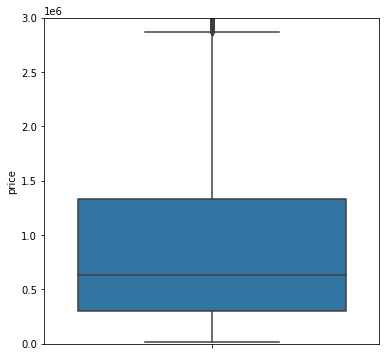

In [13]:
plt.figure(figsize=(6, 6))
plt.ylim(top=3_000_000)
ax = sns.boxplot(y="price", data=train)

> На графике видим, что 75% предложений, это цена до 1_300_000р. И все что свыше  3 млн. рублей - считается выбросами 

In [14]:
len(train[train['price']>3_000_000])

4965

In [15]:
print(f'Общая доля выбросов по признаку "price" :', round(len(train[train['price']>3_000_000])/len(train) * 100,2), '%')

Общая доля выбросов по признаку "price" : 7.77 %


In [16]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [17]:
my_describe(test)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,bodyType,object,34686,0,24,NaN,NaN,NaN,NaN
1,brand,object,34686,0,12,NaN,NaN,NaN,NaN
2,car_url,object,34686,0,34686,NaN,NaN,NaN,NaN
3,color,object,34686,0,16,NaN,NaN,NaN,NaN
4,complectation_dict,object,6418,28268,2364,NaN,NaN,NaN,NaN
5,description,object,34686,0,31732,NaN,NaN,NaN,NaN
6,engineDisplacement,object,34686,0,55,NaN,NaN,NaN,NaN
7,enginePower,object,34686,0,315,NaN,NaN,NaN,NaN
8,equipment_dict,object,24690,9996,23705,NaN,NaN,NaN,NaN
9,fuelType,object,34686,0,5,NaN,NaN,NaN,NaN


In [18]:
# В train отсутствует признак Image, поэтому в test сразу его удалим
test.drop(['image'], axis=1,inplace=True)

## Data Preprocessing

In [19]:
# сохраним целевую переменную, а после удалим из тренировочного датасета
y = train['price']

In [20]:
train.drop(['price'], axis=1,inplace=True)

In [138]:
df_train = train#[columns]
df_test = test#[columns]

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

### 1. Первичный отсмотр данных

In [139]:
my_describe(data)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,bodyType,object,98612,0,26,NaN,NaN,NaN,NaN
1,brand,object,98612,0,133,NaN,NaN,NaN,NaN
2,car_url,object,98612,0,98612,NaN,NaN,NaN,NaN
3,color,object,98612,0,16,NaN,NaN,NaN,NaN
4,complectation_dict,object,70344,28268,6765,NaN,NaN,NaN,NaN
5,description,object,98612,0,81952,NaN,NaN,NaN,NaN
6,engineDisplacement,object,98612,0,74,NaN,NaN,NaN,NaN
7,enginePower,object,98612,0,424,NaN,NaN,NaN,NaN
8,equipment_dict,object,88613,9999,63176,NaN,NaN,NaN,NaN
9,fuelType,object,98612,0,5,NaN,NaN,NaN,NaN


In [140]:
#Удалим столбцы не несущие в себе параметры автомобиля, и не влиящие на предсказание цены 
data.drop(['car_url', 'parsing_unixtime', 'sell_id'], axis=1,inplace=True)
# В связи с отсутствие времени на обработку текста, также удалим 'description'
data.drop(['description'], axis=1,inplace=True)

### Работа с пропусками

bodyType                    0
brand                       0
color                       0
complectation_dict      28268
engineDisplacement          0
enginePower                 0
equipment_dict           9999
fuelType                    0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
priceCurrency               0
productionDate              0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
sample                      0
dtype: int64

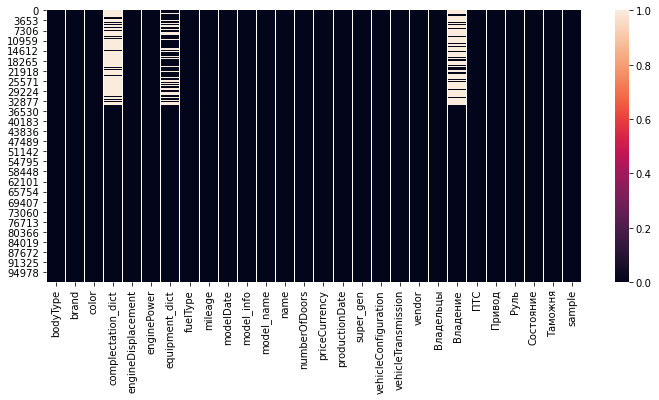

In [141]:
# построим карту пропусков данных
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(data.isnull(), cbar=True)
data.isnull().sum()

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком! По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [142]:
# Подсчитаем общее число строк с пропусками
data.shape[0] - data.dropna().shape[0]

31170

In [143]:
#пропуски в значительном количестве наблюдаем о в столбцах "complectation_dict",'equipment_dict' и 'Владение'.
#Создадим новые столбцы с признаком пропуска данных в них
cols ={"complectation_dict",'equipment_dict', 'Владение'}
for col in cols:
    data[f'{col}_isNAN'] = pd.isna(data[col]).astype('uint8')

In [144]:
# один пропуск наблюдаем в "ПТС". Заполним его самым частым значением: data["ПТС"].value_counts().index[0]
data["ПТС"] = data["ПТС"].fillna(data["ПТС"].value_counts().index[0])

#### Признак "complectation_dict"

In [145]:
data["complectation_dict"].value_counts()

{"id":"0"}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

> Самым частым непустым значением в столбце является значение {"id":"0"}. Чтобы не нарушать структуру данных оставим его без изменений, и им заполним пропуски в столбце. И ячейкам в  ['complectation_dict_isNAN'], соответствующих этому значению, присвоим единицу 

In [146]:
data["complectation_dict"] = data["complectation_dict"].fillna('{"id":"0"}')
data['complectation_dict_isNAN'] = data["complectation_dict"].apply(lambda x: 1 if x == '{"id":"0"}' else 0)
data['complectation_dict_isNAN'] = data['complectation_dict_isNAN'].astype('uint8')

#### Признак "equipment_dict"

In [147]:
data["equipment_dict"].value_counts()

{"gbo":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [148]:
# Наиболее универсального варианта здесь не видно, поэтому присвоим пропускам значение : {"unknown" :true}

In [149]:
data["equipment_dict"] = data["equipment_dict"].fillna('{"unknown" :true}')

#### Признак "Владение"

In [150]:
  data["Владение"].value_counts()  

1 месяц                2407
2 года и 1 месяц       1221
11 месяцев             1190
2 года и 4 месяца      1171
1 год                  1161
                       ... 
60 лет и 10 месяцев       1
36 лет и 5 месяцев        1
26 лет и 7 месяцев        1
39 лет и 8 месяцев        1
24 года и 7 месяцев       1
Name: Владение, Length: 415, dtype: int64

In [151]:
data['Владельцы'][data["Владение"].isnull()].value_counts()

3 или более    10382
1 владелец      6324
2 владельца     5985
Name: Владельцы, dtype: int64

Так как  машины с пропусками в признаке "Владение" выпущены в разные годы (большинство не новые из автосалона), и зачастую имели более одного владельца, то пропуски заполним значением: 'Неизвестно'  

In [152]:
data["Владение"] = data["Владение"].fillna('Неизвестно')

In [153]:
my_describe(data)

,Имя признака,Тип,Всего значений,Число пропусков,Кол-во уникальных,Минимум,Максимум,Среднее,Медиана
0,bodyType,object,98612,0,26,NaN,NaN,NaN,NaN
1,brand,object,98612,0,133,NaN,NaN,NaN,NaN
2,color,object,98612,0,16,NaN,NaN,NaN,NaN
3,complectation_dict,object,98612,0,6765,NaN,NaN,NaN,NaN
4,engineDisplacement,object,98612,0,74,NaN,NaN,NaN,NaN
5,enginePower,object,98612,0,424,NaN,NaN,NaN,NaN
6,equipment_dict,object,98612,0,63177,NaN,NaN,NaN,NaN
7,fuelType,object,98612,0,5,NaN,NaN,NaN,NaN
8,mileage,int64,98612,0,26181,1,1e+06,146432,134000
9,modelDate,int64,98612,0,87,1904,2020,2006.59,2009


In [154]:
# Просматриваем и обрабатываем все признаки

## Обработка признаков

Посмотрим какие признаки у нас могут быть категориальныe, бинарные и числовые:

In [91]:
data.nunique(dropna=False)

bodyType                       26
brand                         133
color                          16
complectation_dict           6765
engineDisplacement             74
enginePower                   424
equipment_dict              63177
fuelType                        5
mileage                     26181
modelDate                      87
model_info                   2579
model_name                   1458
name                         5353
numberOfDoors                   6
priceCurrency                   1
productionDate                 87
super_gen                    9177
vehicleConfiguration          966
vehicleTransmission             4
vendor                          7
Владельцы                       5
Владение                      416
ПТС                             2
Привод                          3
Руль                            2
Состояние                       2
Таможня                         1
sample                          2
Владение_isNAN                  2
equipment_dict

In [92]:
# сформируем списки столбцов по группам исходя из типов признаков
num_cols = ['mileage', 'modelDate', 'productionDate']
bin_cols =['Руль', 'Состояние', 'Таможня', 'ПТС'] 
category_cols = ['model_info', 'model_name', 'name', 'super_gen', 'complectation_dict', 'equipment_dict',  'bodyType', 'brand', 'engineDisplacement', 'color', 'enginePower', 'fuelType', 'numberOfDoors', 
                 'priceCurrency',  'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'Привод']
# 'priceCurrency' - тип валюты. В настоящее время у нас только рубли, но могут быть и др. варианты. Поэтому отнесем к категориальным данным 

SyntaxError: unexpected EOF while parsing (<ipython-input-92-c020068f7fa1>, line 5)

,Имя признака,IQR,perc25,perc75,Л. граница выбросов,П. граница выбросов
0,mileage,125430,74569.5,200000,-113576,388146
1,modelDate,10,2003,2013,1988,2028
2,productionDate,9,2006,2015,1992.5,2028.5


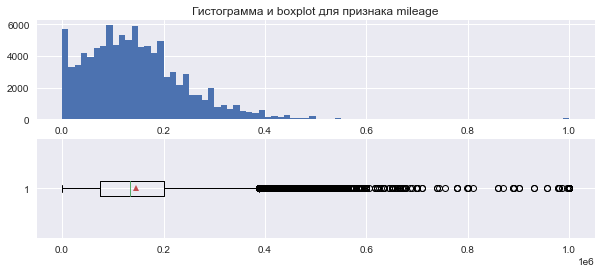

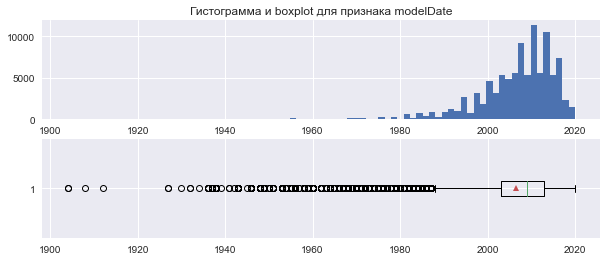

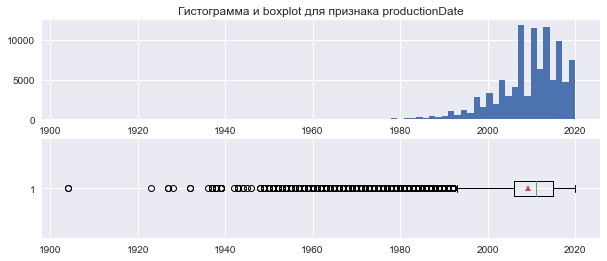

In [68]:
# посмотрим параметры IQR, гистограммы и боксплоты числовых признаков
IQR_perc(data, num_cols)
for column in num_cols:
    show_plot_boxplot(data,column)

Выводы:

По графикам и предыдущим таблицам видно, что основное число машин  произведено примерно в 2010г и в среднем имеют пробег 146_000 км. Данные разрежены, позднее логарифмируем их

In [102]:
# Посмотрим какие значения имеет engineDisplacement
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', '3.5 LTR', '1.7 LTR', '0.7 LTR',
       '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR', '3.8 LTR',
       '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR', '5.5 LTR',
       '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR', '5.7 LTR',
       '0.9 LTR', '6.4 LTR', '0.2 LTR', '7.5 LTR', '7.2 LTR', '7.7 LTR',
       '7.0 LTR', '8.2 LTR', '0.4 LTR', '6.5 LTR', '7.4 LTR', '0.8 LTR',
       '7.3 LTR', '6.8 LTR', '0.6 LTR', '8.1 LTR', '6.1 LTR', '6.7 LTR',
       '8.0 LTR'], dtype=object)

In [101]:
# Заменим пропущенные значения data.engineDisplacement на самое частое значение
data.engineDisplacement.replace(' LTR', data.engineDisplacement.value_counts().index[0], inplace=True)

# переведем  data.engineDisplacement в числовые значения
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x[:3]))

Попытка удаления выбросов в тренировочном датасете метрику не улучшило

In [132]:
# Посмотрим какие значения имеет enginePower
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [131]:
# Заменим пропущенные значения enginePower на самое частое значение
data.enginePower.replace('undefined N12', data.enginePower.value_counts().index[0], inplace=True)

# переведем  data.enginePower в числовые значения
data.enginePower = data.enginePower.apply(lambda x: int(x.split(' ')[0]))

0        105
1        110
2        152
3        110
4        152
        ... 
98607    190
98608    249
98609    167
98610    150
98611    245
Name: enginePower, Length: 98612, dtype: int64

### Числовые признаки

In [69]:
# Для проверки корреляции возьмем числовые признаки тренировочного датасета 
# и присоединим к ним целевую переменную в виде датафрейма df
X = data.query('sample == 1').drop(['sample'], axis=1)

df = pd.DataFrame(X[num_cols]).reset_index()
df.drop(['index'], axis=1,inplace=True)
df['price']=y
df

,mileage,modelDate,productionDate,price
0,48000,1904,1904,7500000
1,1000,1908,1923,3800000
2,5000,1927,1927,4950000
3,1000,1912,1927,3000000
4,2000,1927,1928,3350000
...,...,...,...,...
63921,500,2017,2020,2997600
63922,500,2018,2020,5020000
63923,500,2018,2020,2330000
63924,500,2019,2020,2649750


<AxesSubplot:>

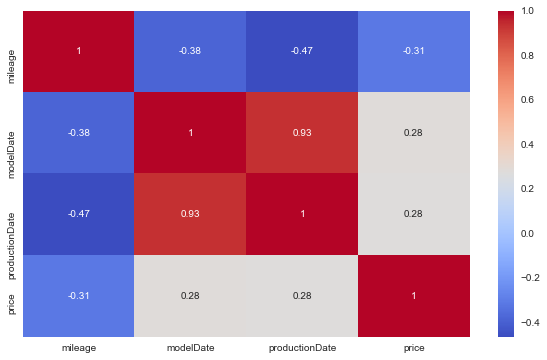

In [70]:
correlation = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Видим, что modelDate и ProductionDate (как и ожидалось сильно коррелируют между собою) и достаточно сильно коррелируют с целевой переменной (ценой). Пробег же на целевую переменную влияет очень слабо

'180'

### Бинарные признаки

In [71]:
# Переведем бинарные признаки в числа при  LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,bodyType,brand,color,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,priceCurrency,productionDate,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,Владение_isNAN,complectation_dict_isNAN,equipment_dict_isNAN
0,лифтбек,SKODA,синий,"{""id"":""0""}",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,RUB,2014,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,Неизвестно,1,передний,0,1,0,0,1,1,0
1,лифтбек,SKODA,чёрный,"{""id"":""0""}",1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,RUB,2017,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,Неизвестно,1,передний,0,1,0,0,1,1,0
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,RUB,2014,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,Неизвестно,1,передний,0,1,0,0,1,0,0
3,лифтбек,SKODA,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,RUB,2014,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,Неизвестно,1,передний,0,1,0,0,1,0,0
4,лифтбек,SKODA,белый,"{""id"":""0""}",1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,RUB,2012,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,Неизвестно,1,передний,0,1,0,0,1,1,0


### Категориальные признаки

Осмотрим значения признаков имеющих неболшое количество значений: 

In [72]:
for col in ['bodyType', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'numberOfDoors', 'priceCurrency', 
'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'Привод']:
    print(f'{col}: {data[col].unique()}')

bodyType: ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'спидстер' 'хэтчбек 4 дв.']
color: ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
engineDisplacement: ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LTR' '4.4 LTR' '4.8 LTR' '5.4 LTR' '6.

In [73]:
# В признаке 'Владельцы' заменим юникодовский пробел на ascii пробел
data["Владельцы"] = data["Владельцы"].str.replace(u'\xa0', '')

In [74]:
# Переведем категориальные признаки в числа
# в алфавитном порядке 
"""label_encoder = LabelEncoder()

for column in category_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()"""

for colum in category_cols:
    data[colum] = data[colum].astype('category').cat.codes

## Создание новых признаков

In [75]:
data['km_in_year'] = data['mileage'] / ((datetime.datetime.now().year +1) - data['productionDate'])
num_cols.append('km_in_year')

# Введение данных признаков (атикварные и старые автомобили ) немного ухудшило метрику

#data['antique_car'] = data['productionDate'].apply(lambda x: 1 if x<(datetime.datetime.now().year-50) else 0)
#data['old_car'] = data['productionDate'].apply(lambda x: 1 if \
#((datetime.datetime.now().year-50)<= x <=(datetime.datetime.now().year-20)) else 0)

In [76]:
# Преобразуем числовые признаки в полиномиальные
poly = PolynomialFeatures(3,interaction_only=True)
data_num = pd.DataFrame(poly.fit_transform(data[num_cols].values))

### Логарифмирование признаков (числовых и целевого)

In [77]:
# Прологарифмируем целевую функцию. А после предсказания взять экспоненту от получившегося рузультата: y=np.exp(y)-1
y= np.log(y+1)
# прологарифмируем числовые признаки и полученные от них полиномиальные признаки
data[num_cols] = np.log(data[num_cols]+1)
data_num = np.log(data_num +1)

,Имя признака,IQR,perc25,perc75,Л. граница выбросов,П. граница выбросов
0,mileage,0.986577,11.2195,12.2061,9.73963,13.6859
1,modelDate,0.00497761,7.6029,7.60788,7.59543,7.61534
2,productionDate,0.00447428,7.6044,7.60887,7.59768,7.61558
3,km_in_year,0.630478,9.12509,9.75557,8.17937,10.7013


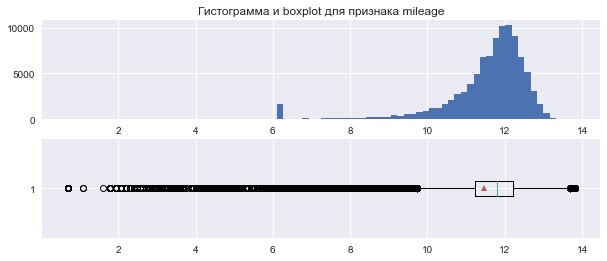

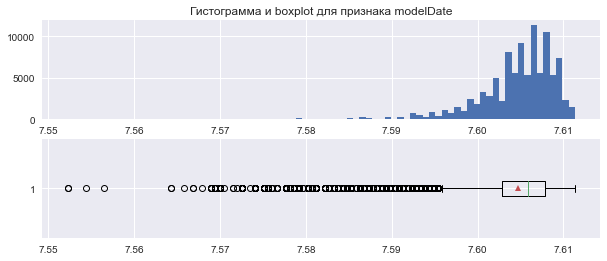

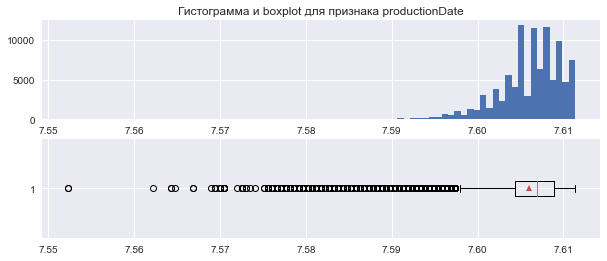

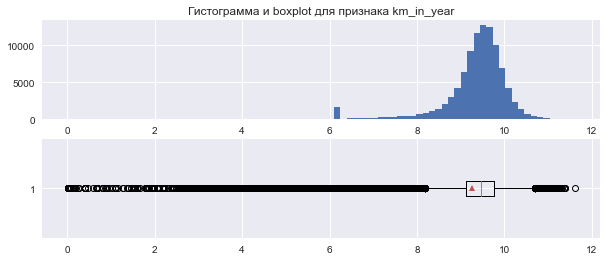

In [78]:
# Посмотрим IQR и боксплоты прологарифмированных числовых признаков
IQR_perc(data, num_cols)
for column in num_cols:
    show_plot_boxplot(data,column)

> **Только mileage  и связанный с ним km_in_year стали менее разреженными**

In [79]:
# Присоединим к датасету ,блок прологарифмированных полиномиальных признаков
data = pd.concat([data,data_num], axis=1)

In [80]:
# отделим тренировочный датасет от тестового:

X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Подготовка данных к машинному обучению

Разделим  тренировочные данные для обучения следующим образом:

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Модели ML

## Model #1: Модель CatBoost c заданными параметрами 


![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [ ]:
# вычисления закомментированы для ускорения записи на Kaggle
model1 = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model1.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
predict = np.round((np.exp(model1.predict(X_test))-1)/1000) *1000
y_test_exp = np.exp(y_test)-1

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Без подбора параметров MAPE составила 16.93% 

In [ ]:
# Не знаю пока что это, но сохраню на будущее
#model1.save_model('catboost_single_model_baseline.model')

### Модель 2 (с найденными лучшими гиперпараметрами)

In [ ]:
# Поиск наилучших параметров для CatBoostRegressor
cbr = CatBoostRegressor()

grid = {'learning_rate': [round(x,3) for x in np.linspace(start = 0.025, stop = 0.4, num = 40)],
        'depth': [int(x) for x in np.linspace(start = 5, stop = 10, num = 5)],
        'l2_leaf_reg': [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]}

#grid_search_result = cbr.grid_search(grid, 
#                                       X=X_train, 
#                                       y=y_train, 
#                                       plot=False)
#print(grid_search_result['params'])

# {'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.083} bestTest = 0.01254271153 bestIteration = 3746

In [ ]:
model2 = CatBoostRegressor(iterations = 3747,
                          learning_rate = 0.083,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth = 7,
                          l2_leaf_reg = 1 
                         )
model2.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
predict = np.round((np.exp(model2.predict(X_test))-1)/1000) *1000
y_test_exp = np.exp(y_test)-1

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.97%
Модель с лучшими параметрами  на  X_sub(test) улучшила метрику на 0.5%

### Model 3. Стекинг

Применим в стекинге  sklearn.StackingRegressor() следующие алгоритмов:  CatBoostRegressor, LinearRegression, KNeighborsRegressor, GradientBoostingRegressor и RandomForestRegressor. И для некоторых попробуем найти оптимальные значения

Подбор параметров для RandomForest  

In [ ]:
# вычисления закомментированы
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
#rf = RandomForestRegressor(random_state = RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
#rf_random.fit(X_train, y_train)
#rf_random.best_params_

#best_params_: 
#{'n_estimators': 200,
 #'min_samples_split': 2,
 #'min_samples_leaf': 2,
 #'max_features': 'auto',
# 'max_depth': None,
# 'bootstrap': True}

In [ ]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=None, bootstrap=True)
#rf.fit(X_train, y_train)

#predict2 = np.round((np.exp(rf.predict(X_test))-1)/1000) *1000
#y_test_exp2 = np.exp(y_test)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp2, predict2))*100:0.2f}%")

Точность модели по метрике MAPE: 17.56%

Подбор параметров для KNeighborsRegressor

In [ ]:

#knr = KNeighborsRegressor()

#cv = 5
#grid = {'n_neighbors': [int(x) for x in np.linspace(start = 3, stop = 7, num = 3)],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]}

#grid_search_result = GridSearchCV(knr, param_grid=grid, cv=cv).fit(X_train, y_train)

#print(grid_search_result.best_params_)
#{'algorithm': 'auto', 'leaf_size': 40, 'n_neighbors': 7, 'weights': 'distance'}

In [ ]:
knr = KNeighborsRegressor(algorithm='auto', leaf_size=40, n_neighbors=7, weights='distance', n_jobs=-1)
#knr.fit(X_train, y_train)

#predict3 = np.round((np.exp(knr.predict(X_test))-1)/1000) *1000
#predict = np.exp(model.predict(X_test))-1
#y_test_exp3 = np.exp(y_test)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp3, predict3))*100:0.2f}%")

Точность модели по метрике MAPE: 48.45%

Подбор параметров для GradientBoostingRegressor провести не удалось в связи с большей  длительностью данного процесса. Поэтому возьмем параметры по умолчанию, установим только n_estimators=300

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED,  warm_start=10,  tol=0.0001)
#gbr.fit(X_train, y_train)

#predict5 = np.round((np.exp(gbr.predict(X_test))-1)/1000) *1000
#y_test_exp5 = np.exp(y_test)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp5, predict5))*100:0.2f}%")

Точность модели по метрике MAPE: 21.16%

### Стекинг. 

1 вариант

In [ ]:
# вычисления закомментированы для ускорения записи на Kaggle
estimators=[
        ('rf1', RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=5, bootstrap=True, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED,  warm_start=10,  tol=0.0001)),
        ('knr', KNeighborsRegressor(algorithm='auto', leaf_size=40, n_neighbors=7, weights='distance', n_jobs=-1)),
            ]

reg1 = StackingRegressor(estimators=estimators,
     final_estimator = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.083,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth=7,
                          l2_leaf_reg=1               
                        )
                    )

    
#reg1.fit(X, y)

#predict = np.round((np.exp(reg1.predict(X))-1)/1000) *1000
#y_test_exp = np.exp(y)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 26.05%

2 вариант

In [ ]:
# вычисления закомментированы для ускорения записи на Kaggle
estimators=[
        ('rf1', RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=5, bootstrap=True, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED,  warm_start=10,  tol=0.0001)),
        ('сbr',  CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.083,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth=7,
                          l2_leaf_reg=1)
        )
            ]

reg2 = StackingRegressor(estimators=estimators,
     final_estimator = KNeighborsRegressor(algorithm='auto', leaf_size=40, n_neighbors=7, weights='distance', n_jobs=-1)
                    )

    
#reg2.fit(X, y)

#predict = np.round((np.exp(reg2.predict(X))-1)/1000) *1000
#y_test_exp = np.exp(y)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 17.49%

3 вариант

In [ ]:
estimators=[
        ('rf1', RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=5, bootstrap=True, n_jobs=-1)),
        ('knr', KNeighborsRegressor(algorithm='auto', leaf_size=40, n_neighbors=7, weights='distance', n_jobs=-1)),
        ('сbr',  CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.083,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth=7,
                          l2_leaf_reg=1)
        )
            ]

reg3 = StackingRegressor(estimators=estimators,
     final_estimator = GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED,  warm_start=10,  tol=0.0001)
                    )

    
#reg3.fit(X, y)

#predict = np.round((np.exp(reg3.predict(X))-1)/1000) *1000
#y_test_exp = np.exp(y)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

### **Точность модели по метрике MAPE: 12.50%**

4 вариант

In [ ]:
estimators=[
            ('сbr',  CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.083,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth=7,
                          l2_leaf_reg=1)
        )
            ]

reg4 = StackingRegressor(estimators=estimators,
     final_estimator = GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED,  warm_start=10,  tol=0.0001)
                    )

    
#reg4.fit(X, y)

#predict = np.round((np.exp(reg4.predict(X))-1)/1000) *1000
#y_test_exp = np.exp(y)-1

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test_exp, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.66%

Видим, что основными алгоритмами в стекинге являются CatBoost и GradientBoosting - использование других алгоритмов дает незначительное улучшение модели 

По результатам стекинга видно, что так как CatBoost чувствителен к набору признаков,а так же его оптимальные параметры подобраны для обучения на исходном датасете, без дополнительных признаков, полученных от других алгоритмов, то его лучше ставить в базовый набор алгоритмов стекинга.

Финальным (итоговым) алгоритмом стекинга лучше всего ставить бустинг. В данном случае -  GradientBoosting

# Submission

Вычислим submission на основе 3-ой модели стекинга

In [ ]:
predict_submission = np.round((np.exp(reg3.predict(X_sub))-1)/1000) *1000
predict_submission 

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

* На лидерборде получили 15.24% Видно что стекинг в целом дает хорошие результаты, но сказываются некоторые различия между тренировочным и тестовым датасетом с каггла: возможно за полтора месяца (разница в собирании датасетов) произошло некоторое изменение цены автомобилей?

# Выводы
В итоге видим:


* Попытка удаления выбросов в тренировочном датасете метрику не улучшило
* Добавление новых бинарных признаков несколько ухудшает метрику, но ее улучшает введение полиномиальных
* Логарифмирование числовых и целевого признаков значительно улучшает метрику
* Поиск оптимальных параметров CatBoost незначительно улучшает метрику
* По результатам стекинга видно, что так как CatBoost чувствителен к набору признаков,а так же его оптимальные параметры подобраны для обучения на исходном датасете, без дополнительных признаков, полученных от других алгоритмов, то его лучше ставить в базовый набор алгоритмов стекинга.
* Финальным (итоговым) аглгоритмом стекинга лучше всего ставить бустинг. В данном случае -  GradientBoosting

Почему-то наилучший результат  на тестовом датасете (из каггла) показало использование только CatBoost с оптимальными параметрами. На тренировочном же датасете лучший результат показывает стекинг, с использованием CatBoost, GradientBoosting, RandomForest и  KNeighborsRegressor